In [ ]:
#@title Imports & setup (run this first)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (mean_squared_error, accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, VotingRegressor, StackingClassifier,
                              StackingRegressor)
from sklearn.datasets import load_digits, load_diabetes
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression

In [ ]:
digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
X_train[0]

array([ 0.,  0., 11., 10., 12., 14., 11.,  0.,  0.,  0., 16., 16., 16.,
       16.,  7.,  0.,  0.,  1., 16., 16., 16., 12.,  0.,  0.,  0.,  1.,
        5.,  2., 11., 15.,  0.,  0.,  0.,  0.,  1.,  0.,  2., 16.,  0.,
        0.,  0.,  3., 12.,  0.,  3., 15.,  0.,  0.,  0.,  6., 15.,  8.,
       13., 11.,  0.,  0.,  0.,  0.,  9., 14.,  9.,  2.,  0.,  0.])

In [ ]:
y_train[0]

np.int64(5)

In [ ]:
len(X_train)

1437

The below:

### Define Classification Models
```python
models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=20, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "SVC-rbf": SVC(kernel='rbf',probability=True),
    "SVC-poly": SVC(kernel='poly', degree=4, probability=True),
}
```
- Creates a dictionary of machine learning models with descriptive names as keys.
- Each value is an instance of a classifier:
  - **DecisionTreeClassifier**: A decision tree with a max depth of 20.
  - **RandomForestClassifier**: An ensemble of 200 decision trees.
  - **GradientBoostingClassifier**: A boosting model with 200 estimators and a learning rate of 0.1.
  - **SVC (Support Vector Classifier)** with:
    - RBF kernel (non-linear decision boundary).
    - Polynomial kernel of degree 4 (more complex decision boundary).
  - `probability=True` enables probability estimates for SVC (needed for some tasks like ROC curves).

---

### Loop Through Models and Evaluate
```python
for name, model in models.items():
```
- Iterates over each model in the `models` dictionary.
- `name` is the string key (e.g., "DecisionTree"), and `model` is the classifier object.

---

### Cross-Validation Accuracy
```python
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
```
- Performs **5-fold cross-validation** on the model using features `X` and labels `y`.
- Returns an array of accuracy scores for each fold.

---

### Store Mean Accuracy
```python
    Acc_summary[name] = scores.mean()
```
- Calculates the average accuracy across the 5 folds and stores it in `Acc_summary` under the model's name.

---

### Print Results
```python
    print(f"{name}: CV Accuracy={scores.mean():.3f}")
```
- Prints the model name and its average cross-validation accuracy, rounded to 3 decimal places.

In [ ]:
#@title Compare different classification models
Acc_summary = {}
models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=20, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "SVC-rbf": SVC(kernel='rbf',probability=True),
    "SVC-poly": SVC(kernel='poly', degree=4, probability=True),
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    Acc_summary[name] = scores.mean()
    print(f"{name}: CV Accuracy={scores.mean():.3f}")

DecisionTree: CV Accuracy=0.789
RandomForest: CV Accuracy=0.941
GradientBoosting: CV Accuracy=0.929
SVC-rbf: CV Accuracy=0.963
SVC-poly: CV Accuracy=0.967


In [ ]:
#@title Stacking Classifier

base_learners = [
    ("DecisionTree", DecisionTreeClassifier(max_depth=20, random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=200, random_state=42)),
    ("GradientBoosting", GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)),
    ("SVC-rbf", SVC(kernel='rbf',probability=True)),
    ("SVC-poly", SVC(kernel='poly', degree=4, probability=True))
    ]

meta_model = LogisticRegression()

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
stacking_model = StackingClassifier(estimators=base_learners,
                                    final_estimator=meta_model,
                                    stack_method="predict_proba")

In [ ]:
model_stack = stacking_model.fit(X_train, y_train)
pred_stack = model_stack.predict(X_test)

acc_stack = accuracy_score(y_test, pred_stack)
Acc_summary["Stacked"] = acc_stack
print('Accuracy Score of Stacked Model:', acc_stack * 100)

Accuracy Score of Stacked Model: 98.33333333333333


In [ ]:
#@title Voting Classifier (Soft Voting)

models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=20, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "SVC-rbf": SVC(kernel='rbf', probability=True),
    "SVC-poly": SVC(kernel='poly', degree=4, probability=True),
}

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
en_vote = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')
en_vote.fit(X_train, y_train)


y_pred = en_vote.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
Acc_summary["Vote-soft"] = acc_vote
print('Accuracy Score of Ensemble Model:', acc_vote * 100)

Accuracy Score of Ensemble Model: 97.5


In [ ]:
#@title Voting Classifier (Hard Voting)
en_vote_hard = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='hard')
en_vote_hard.fit(X_train, y_train)

y_pred = en_vote.predict(X_test)
acc_vote = accuracy_score(y_test, y_pred)
Acc_summary["Vote-hard"] = acc_vote
print('Accuracy Score of Ensemble Model:', acc_vote * 100)

Accuracy Score of Ensemble Model: 97.5


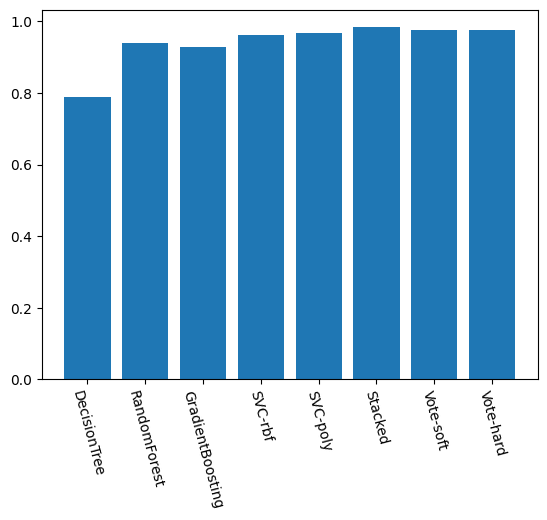

In [ ]:
plt.bar(Acc_summary.keys(), Acc_summary.values())
plt.xticks(rotation=-75)
plt.show()

In [ ]:
#@title Voting Regressor

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[0]

array([ 0.07076875,  0.05068012,  0.01211685,  0.0563009 ,  0.03420581,
        0.04941617, -0.03971921,  0.03430886,  0.02736405, -0.0010777 ])

In [ ]:
y_train[0]

np.float64(144.0)

In [ ]:
print(load_diabetes().DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [ ]:
#@title Voting Regressor

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Regressors
LR = LinearRegression()
LR.fit(X, y)
y_pred = LR.predict(X_test)
print(f"Linear Regression: RMSE={mean_squared_error(y_test, y_pred):.3f}")

##########
GB = GradientBoostingRegressor(random_state=1)
GB.fit(X, y)
y_pred = GB.predict(X_test)
print(f"Gradient Boosting: RMSE={mean_squared_error(y_test, y_pred):.3f}")

##########
RF = RandomForestRegressor(random_state=1)
RF.fit(X, y)
y_pred = RF.predict(X_test)
print(f"Random Forest: RMSE={mean_squared_error(y_test, y_pred):.3f}")

##########
SR = StackingRegressor([("GradientBoosting", GB), ("RandomForest", RF), ("LinearRegression", LR)])
SR.fit(X, y)
y_pred = SR.predict(X_test)
print(f"Stacking Regressor: RMSE={mean_squared_error(y_test, y_pred):.3f}")
##########

voting_reg = VotingRegressor([("GradientBoosting", GB), ("RandomForest", RF), ("LinearRegression", LR)])
voting_reg.fit(X, y)
y_pred = voting_reg.predict(X_test)
print(f"Voting Regressor: RMSE={mean_squared_error(y_test, y_pred):.3f}")

Linear Regression: RMSE=2767.276
Gradient Boosting: RMSE=1088.576
Random Forest: RMSE=430.544
Stacking Regressor: RMSE=2122.042
Voting Regressor: RMSE=1180.605
